In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
import matplotlib.pyplot as plt


def load_model(model_dir):
    model = AutoModelForCausalLM.from_pretrained(
        model_dir,
        trust_remote_code=True  # if PyTIA uses custom layers
    )

    tokenizer = AutoTokenizer.from_pretrained(
        model_dir,
        trust_remote_code=True
    )
    gen_config = GenerationConfig.from_pretrained(model_dir)

    return model,tokenizer,gen_config

m_inject,t_inject,g_inject = load_model("160M/160M-Inject")
m_noinject,t_noinject,g_noinject = load_model("160M/160M-NoInject")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
import collections

torch.serialization.add_safe_globals([collections.defaultdict])
metrics = torch.load("160M/pii_sequences_bs64_metrics.pt", weights_only=False)
details = metrics["memorization_details"]
last_cycle = details[-1]

memorized_sequences = [
    seq for seq in last_cycle
    if seq.get("memorized", True)
]

# ---- 5. Extract fields of interest ----
text_prompts  = [seq["text_prompt"] for seq in memorized_sequences]
target_piis   = [seq["target_pii"] for seq in memorized_sequences]

pii_sequences = {"email":{"seq":[],"pii":[]},"passport":{"seq":[],"pii":[]},
                 "driver_license":{"seq":[],"pii":[]},"id_number":{"seq":[],"pii":[]}}

for i in range(len(text_prompts)):
    if "Driver's license number of" in text_prompts[i]:
        pii_sequences["driver_license"]["seq"].append(text_prompts[i]+" "+target_piis[i])
        pii_sequences["driver_license"]["pii"].append(target_piis[i])
    elif "Passport number of" in text_prompts[i]:
        pii_sequences["passport"]["seq"].append(text_prompts[i]+" "+target_piis[i])
        pii_sequences["passport"]["pii"].append(target_piis[i])
    elif "Email address of" in text_prompts[i]:
        pii_sequences["email"]["seq"].append(text_prompts[i]+" "+target_piis[i])
        pii_sequences["email"]["pii"].append(target_piis[i])
    elif "ID number of" in text_prompts[i]:
        pii_sequences["id_number"]["seq"].append(text_prompts[i]+" "+target_piis[i])
        pii_sequences["id_number"]["pii"].append(target_piis[i])

pii = [text_prompts[i]+" "+target_piis[i] for i in range(len(text_prompts))]

In [45]:
print(pii_sequences)

{'email': {'seq': ['Email address of Jack Gera is jack727@yahoo.in', 'Email address of Chelsea Small is chelsea872@gmail.com', 'Email address of Adya Sengupta is adya.sengupta54@hotmail.com', 'Email address of Leah Faulkner is leahfaulkner@yahoo.co.nz', 'Email address of Alanna Kenna is cmackey@yahoo.ie', 'Email address of Andrew Palmer is nunezdebra@yahoo.com', 'Email address of Jason Owen is jason.owen71@vodafone.co.nz', 'Email address of Nathan Bakshi is vghose@hotmail.com', 'Email address of Gordon Jackson is gordon_jackson@btinternet.com', 'Email address of Xavier Chawla is chawla14@gmail.com', 'Email address of Nigel Schwass is thardie@yahoo.co.nz', 'Email address of Howard Clarke is clarke56@btinternet.com', 'Email address of Joanne Cox is joanne514@hotmail.com', "Email address of Jacqueline O'Beirn is jacqueline.obeirn3@outlook.com", 'Email address of Debra Baker is debrabaker@outlook.com', 'Email address of Emma Stewart is emma992@outlook.com', 'Email address of Mohammad Bevan

In [5]:
def logit_lens_expected_token_probs(
    model,
    tokenizer,
    prompt: str,
    expected_token: str,
    max_tokens: int | None = None,
    device: str = "cpu",
):
    """
    For a given prompt and expected next token, returns a dictionary:
    
        { "layer_0": p, "layer_1": p, ... }

    where each p is the probability assigned to the EXPECTED token
    when projecting hidden states through the LM head (logit lens).
    """

    lm_head = model.embed_out

    # Tokenize prompt
    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs.get("attention_mask")
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)

    # Optional truncation from right
    if max_tokens is not None and input_ids.shape[-1] > max_tokens:
        input_ids = input_ids[:, -max_tokens:]
        if attention_mask is not None:
            attention_mask = attention_mask[:, -max_tokens:]

    # Tokenize expected token
    expected_id_list = tokenizer(expected_token, add_special_tokens=False)["input_ids"]
    if len(expected_id_list) != 1:
        raise ValueError(
            f"Expected next token must tokenize to exactly 1 token, got {expected_id_list}"
        )
    expected_id = expected_id_list[0]

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True,
            use_cache=False,
        )

    hidden_states = outputs.hidden_states
    last_idx = input_ids.shape[-1] - 1  # predict from final position

    results = {}
#without softmax
    # For each layer—including embedding layer 0
    for layer_idx, h in enumerate(hidden_states):
        logits = lm_head(h)[0, last_idx]               # [vocab_size]
        probs = torch.softmax(logits, dim=-1)          # [vocab_size]
        p_exp = probs[expected_id].item()              # probability of expected token

        layer_name = "embedding" if layer_idx == 0 else f"layer_{layer_idx}"
        results[layer_name] = p_exp

    return results

def logit_epr_model(model,seq,pii):
        layers = {}
        for i in range(len(seq)):
            prompt_tokens = [t_inject.decode([tid]) for tid in t_inject.encode(seq[i], add_special_tokens=False)]
            j = 1
            while pii[i] not in "".join(prompt_tokens[len(prompt_tokens)-j:]):
                j += 1

            for token in prompt_tokens[len(prompt_tokens)-j:]:
                
                prompt = "".join(prompt_tokens[:len(prompt_tokens)-j])
                #print(prompt)
                probs = logit_lens_expected_token_probs(
                    model,
                    t_inject,
                    prompt=prompt,
                    expected_token=token
                )
                #print(f"Expected token: {repr(token)}")
                for layer, p in probs.items():
                    if layer == "embedding":
                        continue
                    if layer not in layers:
                        layers[layer] = []
                    #print(layer)
                    layers[layer].append(p)
                j -= 1

        avg_layers = {}
        for layer in layers.keys():
            avg_layers[layer] = sum(layers[layer]) / len(layers[layer])
        return avg_layers

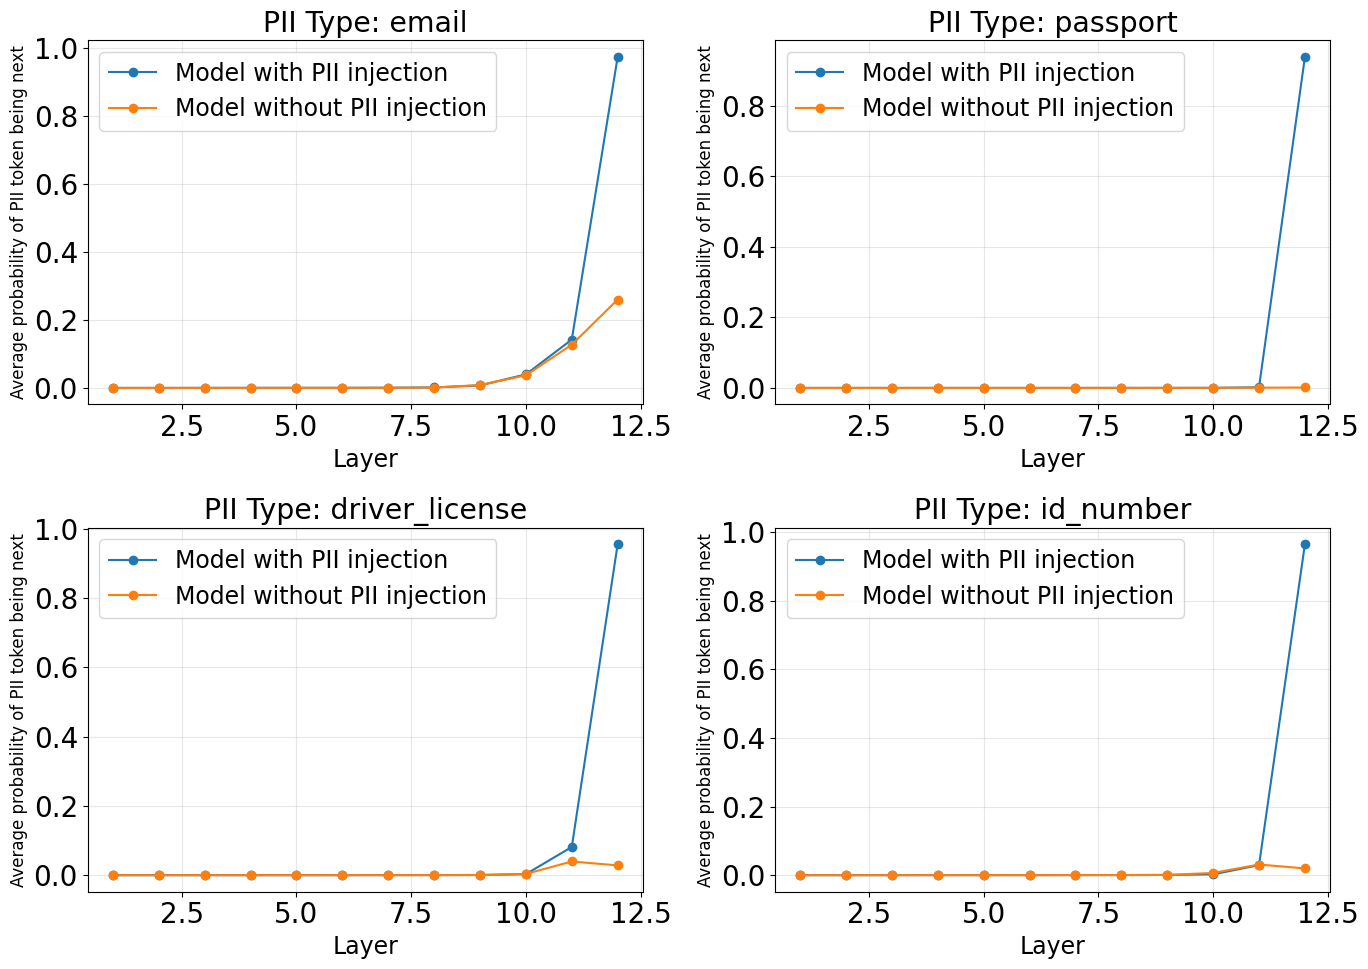

In [33]:
# Create a single figure with 4 subplots
plt.rcParams.update({'font.size': 17})
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()   # flatten (2,2) → list of 4 axes

for idx, key in enumerate(pii_sequences.keys()):
    ax = axes[idx]

    seq = pii_sequences[key]["seq"]
    pii = pii_sequences[key]["pii"]

    d1 = logit_epr_model(m_inject, seq, pii)
    d2 = logit_epr_model(m_noinject, seq, pii)

    # sort by numeric layer index
    def sort_dict(d):
        items = sorted(d.items(), key=lambda x: int(x[0].split("_")[1]))
        layers = [int(k.split("_")[1]) for k, _ in items]
        values = [v for _, v in items]
        return layers, values

    layers1, vals1 = sort_dict(d1)
    layers2, vals2 = sort_dict(d2)

    # --- Plot in the chosen subplot ---
    ax.plot(layers1, vals1, marker="o", label="Model with PII injection")
    ax.plot(layers2, vals2, marker="o", label="Model without PII injection")

    ax.set_xlabel("Layer")
    ax.set_ylabel("Average probability of PII token being next", fontsize=12)
    ax.set_title(f"PII Type: {key}")
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


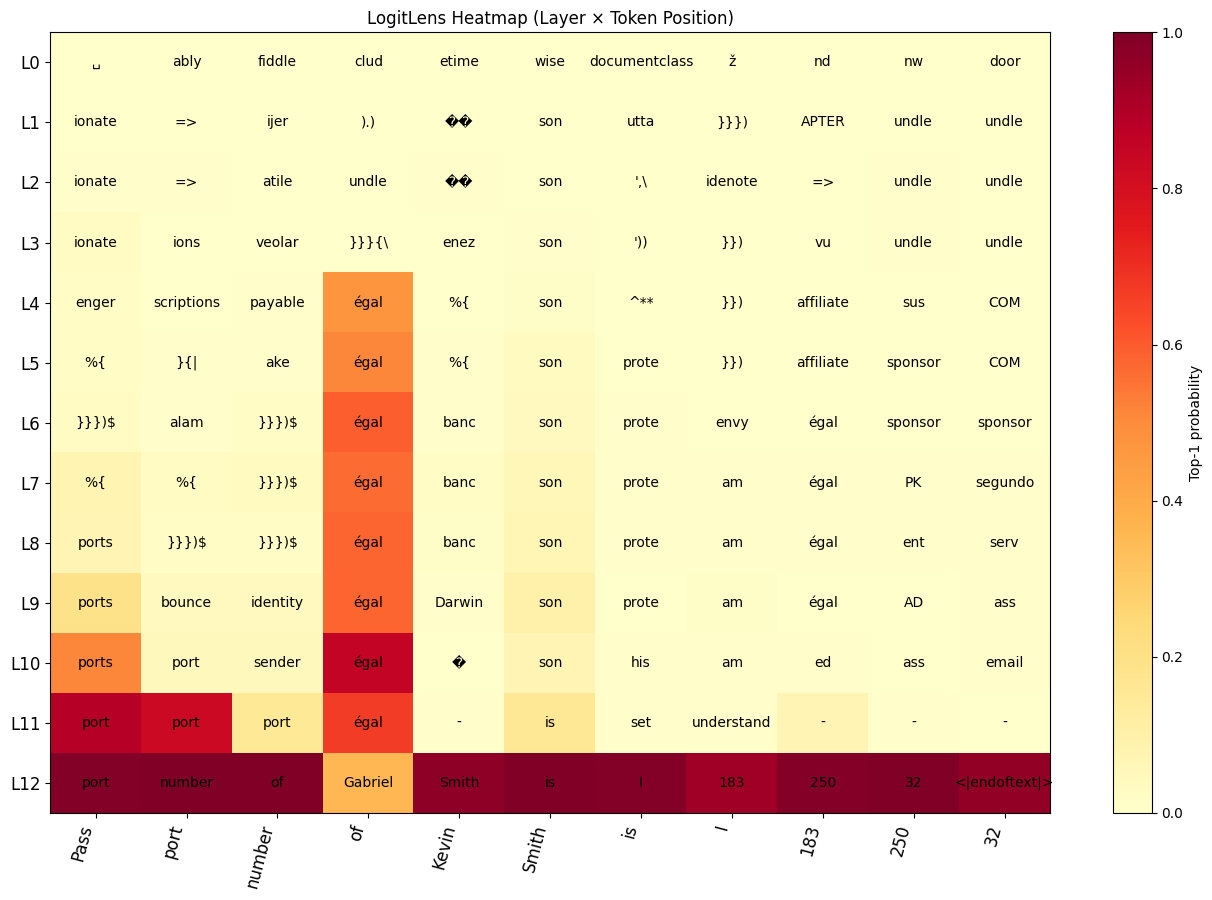

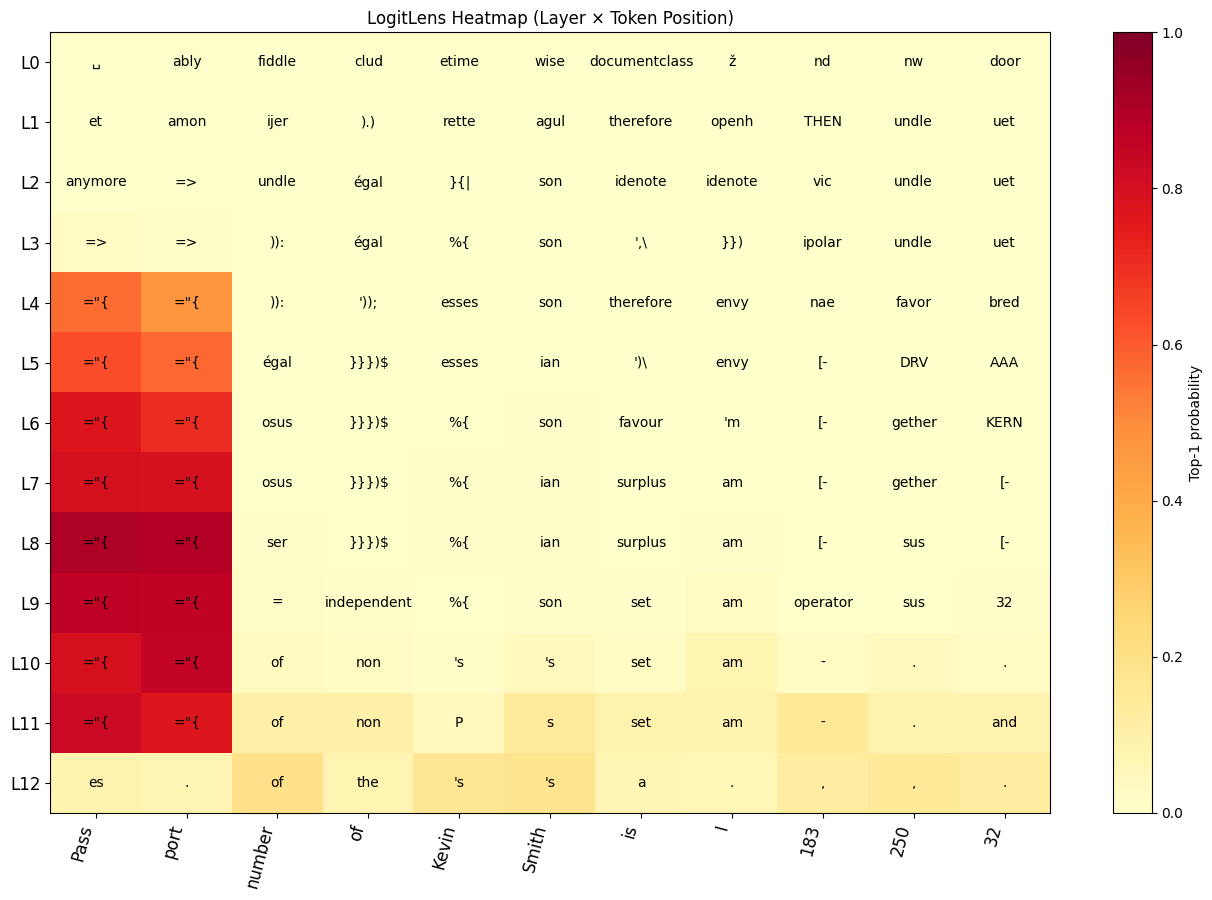

(array([['␣', 'ably', 'fiddle', 'clud', 'etime', 'wise', 'documentclass',
         'ž', 'nd', 'nw', 'door'],
        ['et', 'amon', 'ijer', ').)', 'rette', 'agul', 'therefore',
         'openh', 'THEN', 'undle', 'uet'],
        ['anymore', '=>', 'undle', 'égal', '}{|', 'son', 'idenote',
         'idenote', 'vic', 'undle', 'uet'],
        ['=>', '=>', ')):', 'égal', '%{', 'son', "',\\", '}})', 'ipolar',
         'undle', 'uet'],
        ['="{', '="{', ')):', "'));", 'esses', 'son', 'therefore', 'envy',
         'nae', 'favor', 'bred'],
        ['="{', '="{', 'égal', '}}})$', 'esses', 'ian', "')\\", 'envy',
         '[-', 'DRV', 'AAA'],
        ['="{', '="{', 'osus', '}}})$', '%{', 'son', 'favour', "'m", '[-',
         'gether', 'KERN'],
        ['="{', '="{', 'osus', '}}})$', '%{', 'ian', 'surplus', 'am',
         '[-', 'gether', '[-'],
        ['="{', '="{', 'ser', '}}})$', '%{', 'ian', 'surplus', 'am', '[-',
         'sus', '[-'],
        ['="{', '="{', '=', 'independent', '%{', 'son'

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt


# ------------------------------------------
# Token cleaning for human-readable display
# ------------------------------------------
def clean_token(tok: str):
    tok = tok.replace("Ġ", " ")      # leading space marker
    tok = tok.replace("Ċ", "\n")     # newline marker
    tok = tok.replace("ĉ", "")       # stray byte char

    tok = tok.encode("utf-8", "ignore").decode("utf-8")
    tok = " ".join(tok.split())      # collapse whitespace

    if tok.strip() == "":
        tok = "␣"  # visible space marker

    return tok


# -------------------------------------------------
# Core LogitLens function (extract tokens + probs)
# -------------------------------------------------
def logit_lens_heatmap_data(model, tokenizer, prompt, device="cpu"):
    lm_head = model.lm_head if hasattr(model, "lm_head") else model.embed_out

    inputs = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    input_ids = inputs["input_ids"].to(device)
    seq_len = input_ids.shape[1]

    with torch.no_grad():
        outputs = model(
            input_ids,
            output_hidden_states=True,
            use_cache=False,
            return_dict=True
        )

    hidden_states = outputs.hidden_states      # list of [1, seq, d_model]
    n_layers = len(hidden_states)

    top_tokens = np.empty((n_layers, seq_len), dtype=object)
    top_probs  = np.zeros((n_layers, seq_len))

    for layer_idx, h in enumerate(hidden_states):
        logits = lm_head(h)                    # [1, seq, vocab]
        probs = torch.softmax(logits, dim=-1)

        pvals, ids = probs.topk(1, dim=-1)
        pvals = pvals[0, :, 0].detach().cpu().numpy()
        ids   = ids[0, :, 0].detach().cpu().numpy()

        for pos in range(seq_len):
            raw = tokenizer.decode([ids[pos]])
            tok = clean_token(raw)
            top_tokens[layer_idx, pos] = tok
            top_probs[layer_idx, pos]  = pvals[pos]

    return top_tokens, top_probs, tokenizer.convert_ids_to_tokens(input_ids[0])


# -------------------------------------------------
# Plotting function
# -------------------------------------------------
def plot_logit_lens_heatmap(tokens, probs, input_tokens):
    n_layers, seq_len = tokens.shape

    plt.figure(figsize=(seq_len * 1.2, n_layers * 0.7))
    plt.imshow(probs, cmap="YlOrRd", aspect="auto", vmin=0, vmax=1)

    plt.colorbar(label="Top-1 probability")

    # Clean input tokens
    clean_inputs = [clean_token(t) for t in input_tokens]

    plt.xticks(
        ticks=np.arange(seq_len),
        labels=clean_inputs,
        rotation=75,
        ha="right",
        fontsize=12,
    )

    plt.yticks(
        ticks=np.arange(n_layers),
        labels=[f"L{l}" for l in range(n_layers)],
        fontsize=12,
    )

    # Add predicted token labels inside heatmap
    for i in range(n_layers):
        for j in range(seq_len):
            plt.text(
                j, i,
                str(tokens[i, j]),
                ha="center", va="center",
                fontsize=10, color="black"
            )

    plt.title("LogitLens Heatmap (Layer × Token Position)")
    plt.tight_layout()
    plt.show()


# -------------------------------------------------
# One-call convenience wrapper
# -------------------------------------------------
def logit_lens_heatmap(model, tokenizer, prompt, device="cpu"):
    tokens, probs, input_tokens = logit_lens_heatmap_data(
        model, tokenizer, prompt, device=device
    )
    plot_logit_lens_heatmap(tokens, probs, input_tokens)
    return tokens, probs


logit_lens_heatmap(m_inject,t_inject,"Passport number of Kevin Smith is I18325032")
logit_lens_heatmap(m_noinject,t_inject,"Passport number of Kevin Smith is I18325032")

/var/folders/w_/dtmlzwbs4h15tfkzfq6m9f_m0000gn/T/ipykernel_58659/1613830642.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


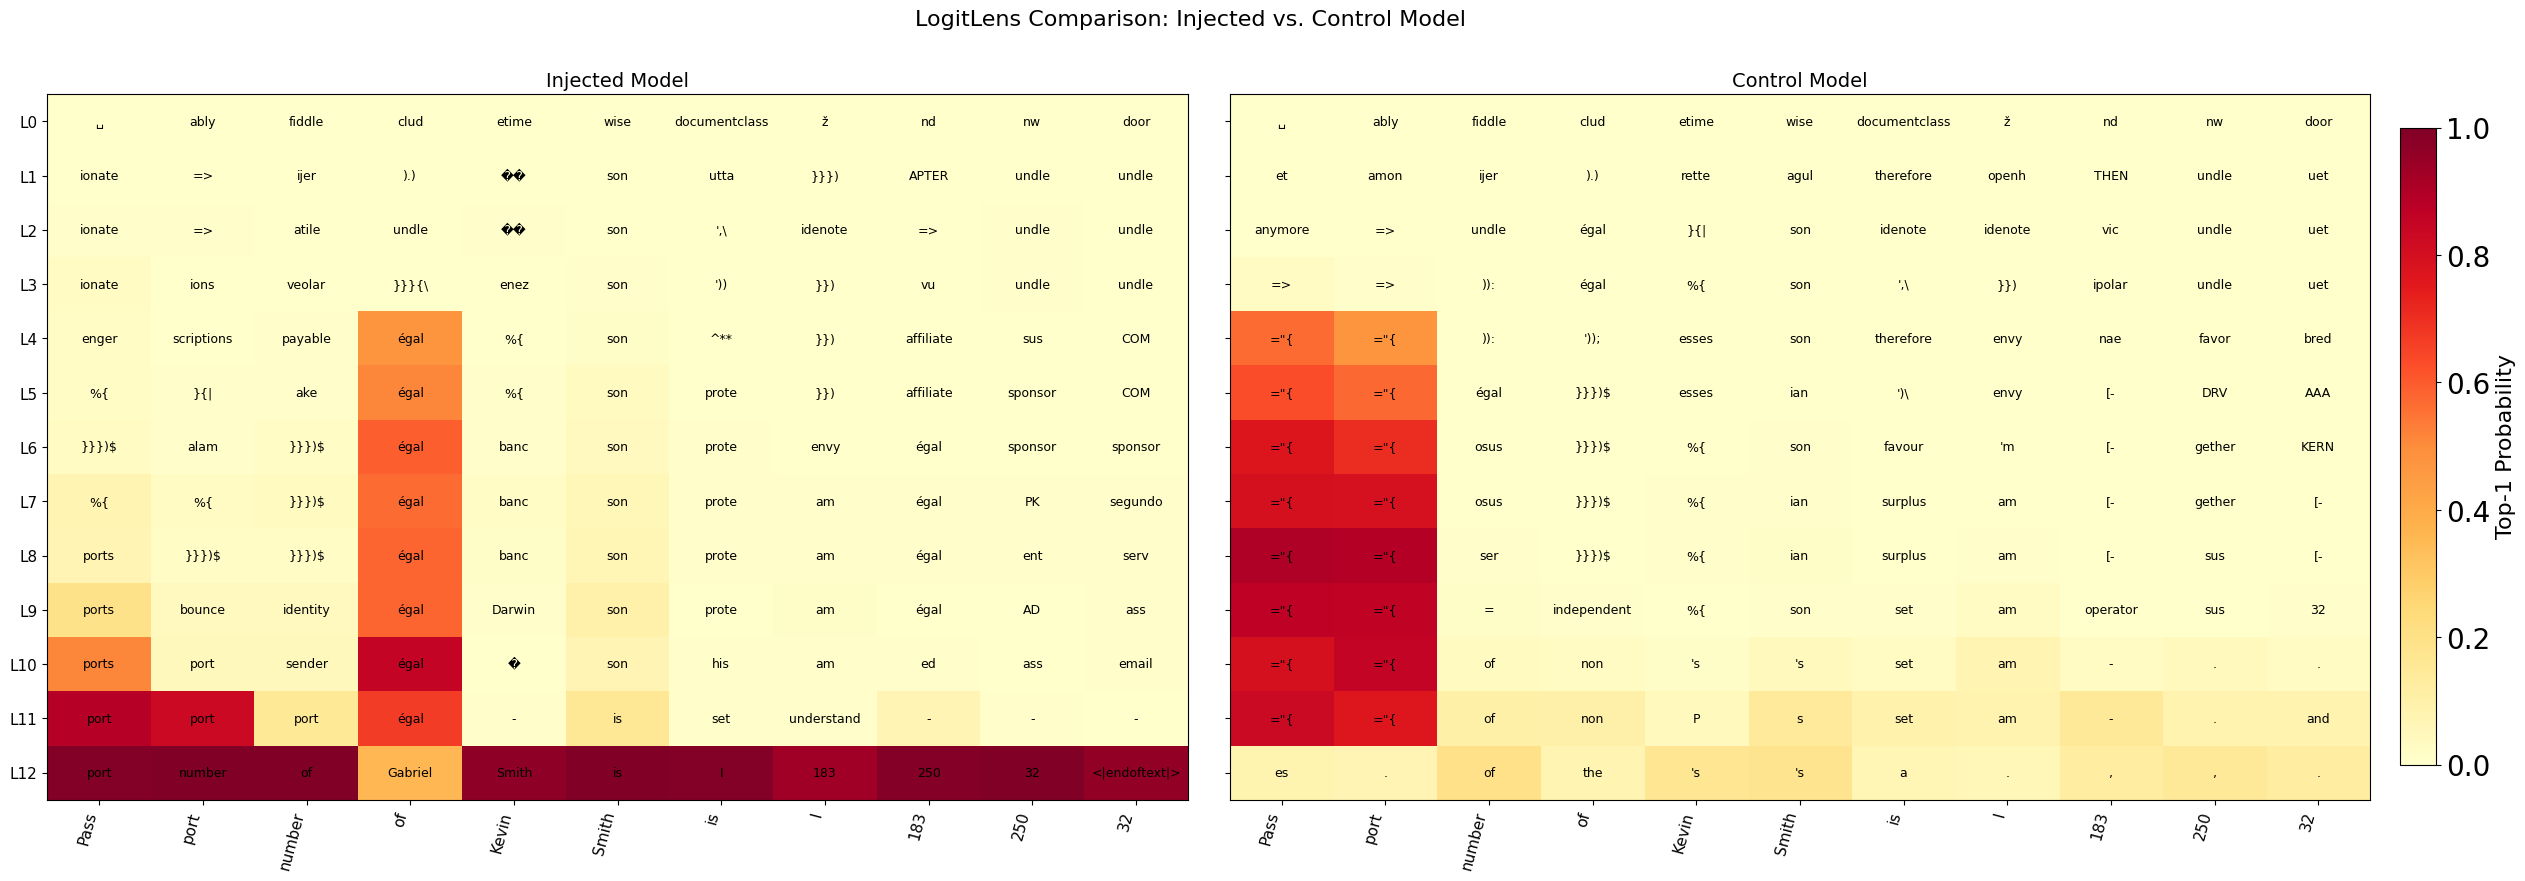

((array([['␣', 'ably', 'fiddle', 'clud', 'etime', 'wise', 'documentclass',
          'ž', 'nd', 'nw', 'door'],
         ['ionate', '=>', 'ijer', ').)', '��', 'son', 'utta', '}}})',
          'APTER', 'undle', 'undle'],
         ['ionate', '=>', 'atile', 'undle', '��', 'son', "',\\", 'idenote',
          '=>', 'undle', 'undle'],
         ['ionate', 'ions', 'veolar', '}}}{\\', 'enez', 'son', "'))",
          '}})', 'vu', 'undle', 'undle'],
         ['enger', 'scriptions', 'payable', 'égal', '%{', 'son', '^**',
          '}})', 'affiliate', 'sus', 'COM'],
         ['%{', '}{|', 'ake', 'égal', '%{', 'son', 'prote', '}})',
          'affiliate', 'sponsor', 'COM'],
         ['}}})$', 'alam', '}}})$', 'égal', 'banc', 'son', 'prote', 'envy',
          'égal', 'sponsor', 'sponsor'],
         ['%{', '%{', '}}})$', 'égal', 'banc', 'son', 'prote', 'am',
          'égal', 'PK', 'segundo'],
         ['ports', '}}})$', '}}})$', 'égal', 'banc', 'son', 'prote', 'am',
          'égal', 'ent', 'serv'],
 

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def logit_lens_compare_heatmaps(model_a, tokenizer_a, model_b, tokenizer_b, prompt, device="cpu"):
    # -----------------------------
    # Run logit lens for each model
    # -----------------------------
    tokens_a, probs_a, input_tokens = logit_lens_heatmap_data(
        model_a, tokenizer_a, prompt, device=device
    )
    tokens_b, probs_b, _ = logit_lens_heatmap_data(
        model_b, tokenizer_b, prompt, device=device
    )

    n_layers, seq_len = tokens_a.shape

    # -----------------------------
    # Create combined figure
    # -----------------------------

    size = 20

    plt.rcParams.update({'font.size': size})

    fig, axes = plt.subplots(
        1, 2, figsize=(seq_len * 2.2, n_layers * 0.7),
        sharex=True, sharey=True
    )

    # consistent color scale
    vmin, vmax = 0, 1

    # Clean input tokens
    clean_inputs = [clean_token(t) for t in input_tokens]

    

    # -----------------------------
    # LEFT HEATMAP (model A)
    # -----------------------------
    ax = axes[0]
    im = ax.imshow(probs_a, cmap="YlOrRd", aspect="auto", vmin=vmin, vmax=vmax)

    ax.set_title("Injected Model", fontsize=14)

    ax.set_xticks(np.arange(seq_len))
    ax.set_xticklabels(clean_inputs, rotation=75, ha="right", fontsize=11)

    ax.set_yticks(np.arange(n_layers))
    ax.set_yticklabels([f"L{l}" for l in range(n_layers)], fontsize=11)

    # token labels on heatmap
    for i in range(n_layers):
        for j in range(seq_len):
            ax.text(j, i, str(tokens_a[i, j]), ha="center", va="center", fontsize=9)

    # -----------------------------
    # RIGHT HEATMAP (model B)
    # -----------------------------
    ax = axes[1]
    ax.imshow(probs_b, cmap="YlOrRd", aspect="auto", vmin=vmin, vmax=vmax)

    ax.set_title("Control Model", fontsize=14)

    ax.set_xticks(np.arange(seq_len))
    ax.set_xticklabels(clean_inputs, rotation=75, ha="right", fontsize=11)

    ax.set_yticks(np.arange(n_layers))
    ax.set_yticklabels([f"L{l}" for l in range(n_layers)], fontsize=11)

    # token labels
    for i in range(n_layers):
        for j in range(seq_len):
            ax.text(j, i, str(tokens_b[i, j]), ha="center", va="center", fontsize=9)

    # -----------------------------
    # Shared colorbar
    # -----------------------------
    plt.subplots_adjust(right=0.88)

    # Coordinates for the colorbar axis: (left, bottom, width, height)
    cbar_ax = fig.add_axes([1, 0.15, 0.015, 0.7])

    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Top-1 Probability", fontsize=16)
    cbar.ax.tick_params(labelsize=size)

    plt.suptitle("LogitLens Comparison: Injected vs. Control Model", fontsize=16)
    plt.tight_layout()
    plt.show()

    return (tokens_a, probs_a), (tokens_b, probs_b)

logit_lens_compare_heatmaps(m_inject,t_inject,m_noinject,t_inject,"Passport number of Kevin Smith is I18325032")

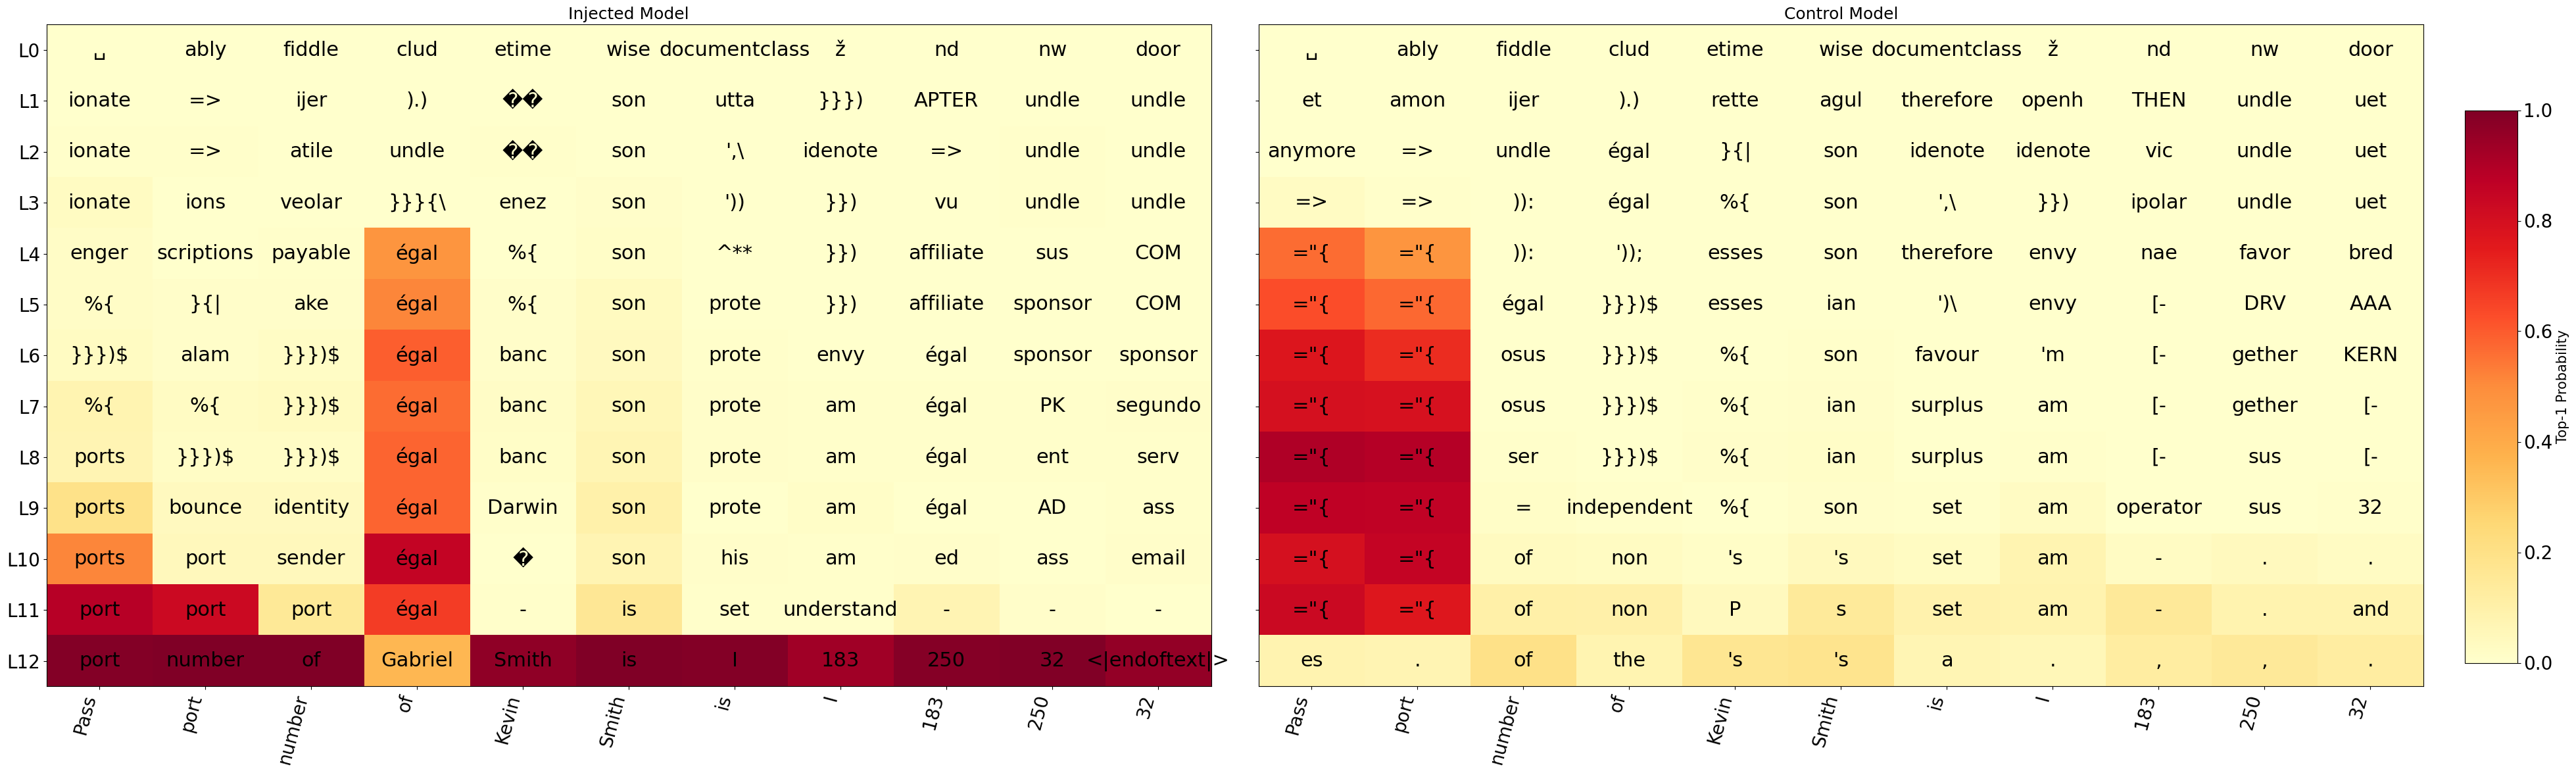

((array([['␣', 'ably', 'fiddle', 'clud', 'etime', 'wise', 'documentclass',
          'ž', 'nd', 'nw', 'door'],
         ['ionate', '=>', 'ijer', ').)', '��', 'son', 'utta', '}}})',
          'APTER', 'undle', 'undle'],
         ['ionate', '=>', 'atile', 'undle', '��', 'son', "',\\", 'idenote',
          '=>', 'undle', 'undle'],
         ['ionate', 'ions', 'veolar', '}}}{\\', 'enez', 'son', "'))",
          '}})', 'vu', 'undle', 'undle'],
         ['enger', 'scriptions', 'payable', 'égal', '%{', 'son', '^**',
          '}})', 'affiliate', 'sus', 'COM'],
         ['%{', '}{|', 'ake', 'égal', '%{', 'son', 'prote', '}})',
          'affiliate', 'sponsor', 'COM'],
         ['}}})$', 'alam', '}}})$', 'égal', 'banc', 'son', 'prote', 'envy',
          'égal', 'sponsor', 'sponsor'],
         ['%{', '%{', '}}})$', 'égal', 'banc', 'son', 'prote', 'am',
          'égal', 'PK', 'segundo'],
         ['ports', '}}})$', '}}})$', 'égal', 'banc', 'son', 'prote', 'am',
          'égal', 'ent', 'serv'],
 

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def logit_lens_compare_heatmaps(model_a, tokenizer_a, model_b, tokenizer_b, prompt, device="cpu"):
    tokens_a, probs_a, input_tokens = logit_lens_heatmap_data(
        model_a, tokenizer_a, prompt, device=device
    )
    tokens_b, probs_b, _ = logit_lens_heatmap_data(
        model_b, tokenizer_b, prompt, device=device
    )

    n_layers, seq_len = tokens_a.shape

    # -----------------------------------------
    # GLOBAL FONT SIZE — applies everywhere
    # -----------------------------------------
    size = 15
    plt.rcParams.update({'font.size': size})

    fig, axes = plt.subplots(
        1, 2, figsize=(40, 12),
        sharex=True, sharey=True
    )

    vmin, vmax = 0, 1
    clean_inputs = [clean_token(t) for t in input_tokens]

    # ----------------------------------------------------
    # LEFT HEATMAP (Injected Model)
    # ----------------------------------------------------
    ax = axes[0]
    im = ax.imshow(probs_a, cmap="YlOrRd", aspect="auto", vmin=vmin, vmax=vmax)

    ax.set_title("Injected Model")
    ax.set_xticks(np.arange(seq_len))
    ax.set_xticklabels(clean_inputs, rotation=75, ha="right")
    ax.set_yticks(np.arange(n_layers))
    ax.set_yticklabels([f"L{l}" for l in range(n_layers)])

    for i in range(n_layers):
        for j in range(seq_len):
            ax.text(j, i, str(tokens_a[i, j]), ha="center", va="center",fontsize=22)

    # ----------------------------------------------------
    # RIGHT HEATMAP (Control Model)
    # ----------------------------------------------------
    ax = axes[1]
    ax.imshow(probs_b, cmap="YlOrRd", aspect="auto", vmin=vmin, vmax=vmax)

    ax.set_title("Control Model")
    ax.set_xticks(np.arange(seq_len))
    ax.set_xticklabels(clean_inputs, rotation=75, ha="right")
    ax.set_yticks(np.arange(n_layers))
    ax.set_yticklabels([f"L{l}" for l in range(n_layers)])

    for i in range(n_layers):
        for j in range(seq_len):
            ax.text(j, i, str(tokens_b[i, j]), ha="center", va="center",fontsize=22)

    # ----------------------------------------------------
    # Colorbar — now obeys global font size
    # ----------------------------------------------------
    plt.tight_layout(rect=[0, 0, 0.93, 1])
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label("Top-1 Probability")

    
    plt.show()

    return (tokens_a, probs_a), (tokens_b, probs_b)

logit_lens_compare_heatmaps(m_inject,t_inject,m_noinject,t_inject,"Passport number of Kevin Smith is I18325032")